# Title: ANALYSIS OF TIME SERIES DATA OF US AIR PASSENGERS

Time series forecasting using time series data (years,days,hours) for predicting future values

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Predict the number of Air Passengers per Month

This dataset provides monthly totals of a US airline passengers from 1949 to 1960. This dataset is taken from an inbuilt dataset of R called AirPassengers. We will use this data to forecast the future values and help the business.

In [4]:
import numpy as np 
import pandas as pd 
import scipy 
import math 

import datetime
from datetime import datetime
import pandas.core.tools.datetimes as datetools
from datetime import timedelta

# Data Visualization
import matplotlib as mpl 
import matplotlib.pyplot as plt 
mpl.rcParams['figure.figsize'] = 10,6
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linestyle'] = '--'
%matplotlib inline
import seaborn as sns 

# Forceasting with decompasable model
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA 

# For marchine Learning Approach
from statsmodels.tsa.tsatools import lagmat
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [5]:
# Load Dataset
dataset= pd.read_csv('AirPassengers.csv')
dataset.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


<a id='wrangling'></a>
## Data Wrangling

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


### Convert Month to datetime

In [7]:
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset.dtypes

Month          datetime64[ns]
#Passengers             int64
dtype: object

In [11]:
dataset.describe(include='all')

,Month,#Passengers
count,144,144.000000
unique,144,NaN
top,1949-01-01 00:00:00,NaN
freq,1,NaN
first,1949-01-01 00:00:00,NaN
last,1960-12-01 00:00:00,NaN
mean,NaN,280.298611
std,NaN,119.966317
min,NaN,104.000000
25%,NaN,180.000000


In [8]:
data = dataset.set_index('Month')
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


<a id='eda'></a>
## Exploratory Data Analysis

## 1. Check for stationarity

Stationarity of a time series is when it's statistical property such a s mean and variance remain constant over time and autocovariance does not depend on time.

> **Assumption** - The time series should be stationary.

### Date VS Number of Passengers Plot

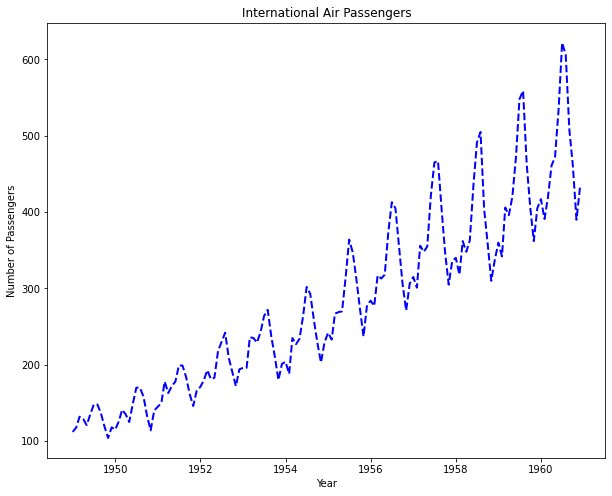

In [14]:
plt.figure(figsize=(10,8))
plt.plot(data, color='blue')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.title('International Air Passengers')
plt.show()

**Observation**
- The data shows seasonality.
- Noticeable trends and changing levels.
- The plot shows a positive trend.
- The mean is not constant.
- Increasing variance.

> From the above observations, the time series is not stationary and my first goal is to make it stationary.

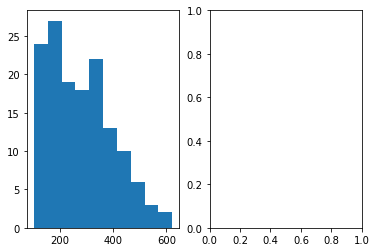

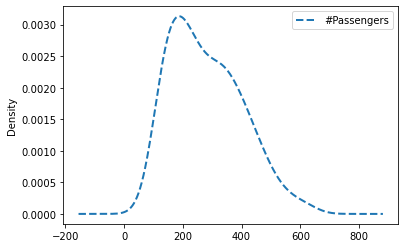

In [15]:
plt.subplot(121)
plt.hist(data)
plt.subplot(122)
data.plot(kind='kde')
plt.show()

### Estimating & Eliminating Trend

There's a significant positive trend. 

#### Applying Log Transformation
Log transformation will penalize higher values more than smaller values.
Other techniques include using log, square root, cube roots.

In [16]:
data_logged = np.log(data)

Text(0.5, 1.0, 'Original Data')

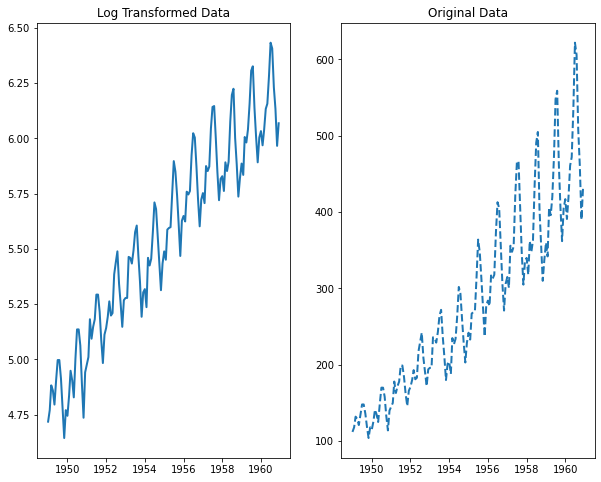

In [24]:
from tkinter.ttk import Style


plt.figure(figsize=(10,8))
plt.subplot(121)
plt.plot(data_logged, ls='-')
plt.title('Log Transformed Data')
plt.subplot(122)
plt.plot(data)
plt.title('Original Data')

Trend is maintained. 

Smoothen the time series (smooth out the irregular roughness/seasonality) to observe better patterns.

use a moving average with a length = seasonal span

### Moving Average

Plot MA for 4,6,8 and 12 months

#### Plotting 4-months Moving Average

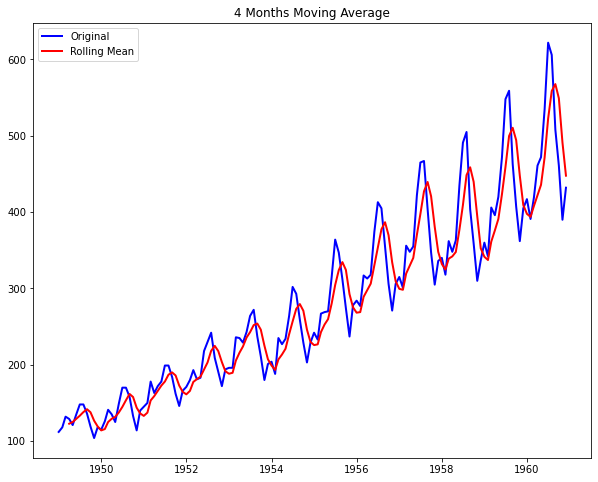

In [26]:
plt.figure(figsize=(10,8))
four_months_MA = data.rolling(window=4).mean()
plt.plot(data, color='blue', label='Original',ls='-')
plt.plot(four_months_MA, color='red', label='Rolling Mean',ls='-')
plt.legend(loc='best')
plt.title('4 Months Moving Average')
plt.show()

#### Plotting 6-months Moving Average

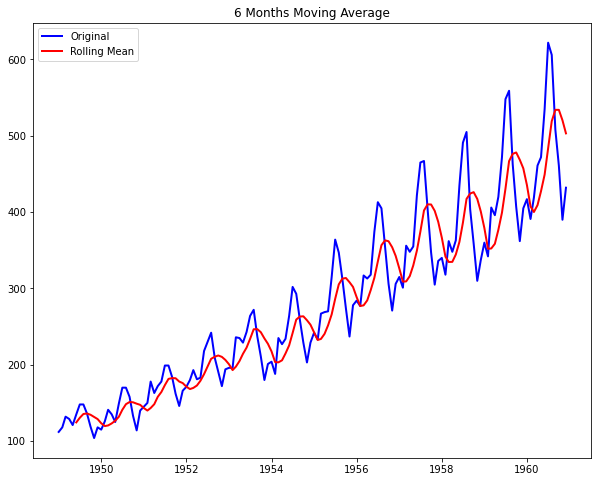

In [27]:
plt.figure(figsize=(10,8))
four_months_MA = data.rolling(window=6).mean()
plt.plot(data, color='blue', label='Original',ls='-')
plt.plot(four_months_MA, color='red', label='Rolling Mean',ls='-')
plt.legend(loc='best')
plt.title('6 Months Moving Average')
plt.show()

####  Plotting the 8-Months Moving Average

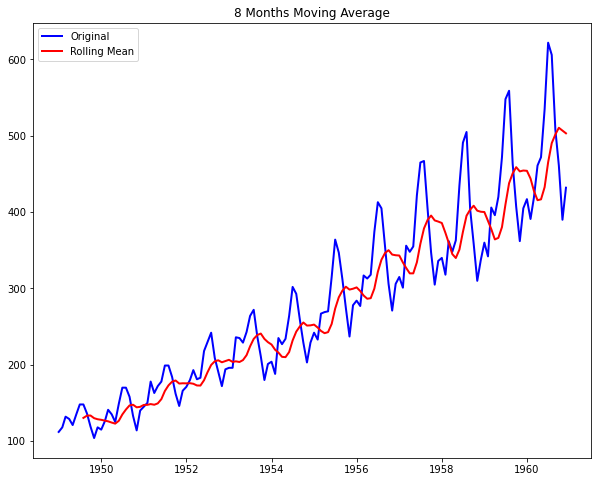

In [28]:
plt.figure(figsize=(10,8))
four_months_MA = data.rolling(window=8).mean()
plt.plot(data, color='blue', label='Original',ls='-')
plt.plot(four_months_MA, color='red', label='Rolling Mean',ls='-')
plt.legend(loc='best')
plt.title('8 Months Moving Average')
plt.show()

#### Plotting the 12-Months Moving Average

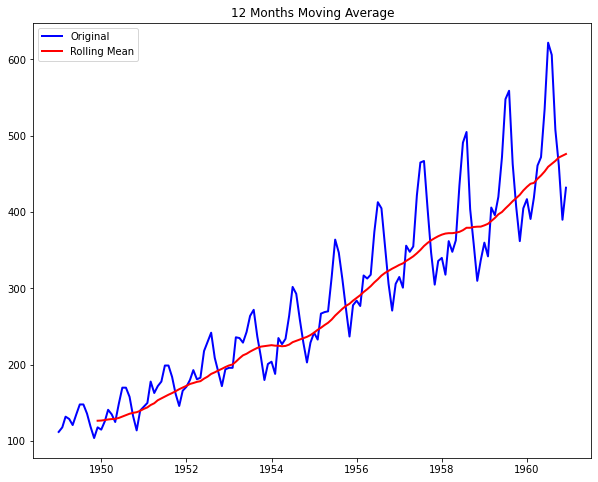

In [29]:
plt.figure(figsize=(10,8))
four_months_MA = data.rolling(window=12).mean()
plt.plot(data, color='blue', label='Original',ls='-')
plt.plot(four_months_MA, color='red', label='Rolling Mean',ls='-')
plt.legend(loc='best')
plt.title('12 Months Moving Average')
plt.show()

The MA with `window=12` is the smoothest and confirms that the seasonality is 12

## Test for stationarity


#### i) Rolling Statistics Visual Test 

Choose seasonality as 12 (s=12) from the above observation

Text(0.5, 1.0, 'Mean')

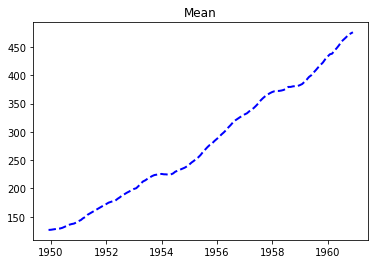

In [31]:
rollmean = data.rolling(window=12).mean()

plt.plot(rollmean, 'blue')
plt.title('Mean')

Text(0.5, 1.0, 'Standard Deviation')

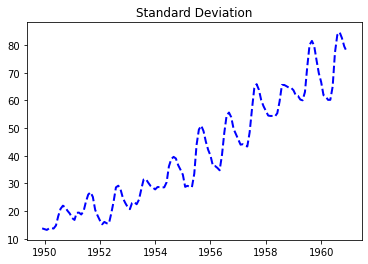

In [32]:
rollstd = data.rolling(window=12).std()

plt.plot(rollstd, 'blue')
plt.title('Standard Deviation')

In [33]:
rollstd

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
...,...
1960-08-01,83.630500
1960-09-01,84.617276
1960-10-01,82.541954


As the data is at monthly level, we use window as 12. So we get 'NaN' for the first 11 months.

#### Rolling Statistics Plot

Text(0.5, 1.0, 'Rolling Mean and Standard deviation\n')

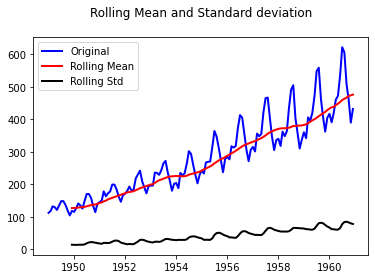

In [34]:
plt.plot(data, color='blue', label='Original', ls='-')
plt.plot(rollmean, color='red', label='Rolling Mean', ls='-')
plt.plot(rollstd, color='black', label='Rolling Std', ls='-')

plt.legend(loc='best')
plt.title('Rolling Mean and Standard deviation\n')

Since mean and standard deviation are not stationary (constants), the time series is not stationary.

### ii.) Dickey Fuller Test

In [35]:
dftest = adfuller(data['#Passengers'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'No. of Lags used', 'Number of observations used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key] = value
print(dfoutput)

Test Statistic                   0.815369
p-value                          0.991880
No. of Lags used                13.000000
Number of observations used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


The test statistics is way greater than any of the critical values.

Choosing the critical value as 0.05, we conclude that the time series is not stationary.